# Potato genomic data analysis - Data preprocessing

*Olivia Angelin-Bonnet*

Preprocessing of the potato genomic data using scikit-allel.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Computing-variants-QD" data-toc-modified-id="Computing-variants-QD-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Computing variants QD</a></span></li><li><span><a href="#Reading-the-VCF-file" data-toc-modified-id="Reading-the-VCF-file-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reading the VCF file</a></span></li><li><span><a href="#Reading-annotation-file" data-toc-modified-id="Reading-annotation-file-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Reading annotation file</a></span></li></ul></div>

In [9]:
import os
import allel
import h5py
import sys
import shlex, subprocess
import pandas as pd
import matplotlib as mpl
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
from itertools import compress
InteractiveShell.ast_node_interactivity = "all"
#hv.extension('bokeh')

In [10]:
plt.rcParams['figure.figsize'] = [15, 15]

In [11]:
# Versions

print('Library versions:')
print('scikit-allel:' ,allel.__version__)
print('h5py:' ,h5py.__version__)

Library versions:
scikit-allel: 1.2.1
h5py: 2.10.0


In [12]:
## File paths
data_path = "../data/"

vcf_file = data_path + "VCF/variants_raw_PGSCv4.03.vcf.gz"
gtf_path = data_path + 'PGSC_DM_V403_fixed_representative_genes.gtf'

In [13]:
## To make sure the folder "processed_data" exists
cmd = "mkdir -p processed_data"
subprocess.run(shlex.split(cmd));

## Computing variants QD

In [14]:
vcf_h5_file = "processed_data/vcf_all_samples.h5" 

In [15]:
## Reading the VCF file and save it in vcf_all_samples.h5
## Uncomment if running for the first time

#allel.vcf_to_hdf5(vcf_file, 
#        vcf_h5_file,
#        fields = "*", ## Get all fields from the VCF file
#        numbers={'GT': 4}, ## ploidy of 4
#        overwrite = True,
#        log = sys.stdout)

In [16]:
## Reading the VCF info saved in a h5 object
callset_all_samples = h5py.File(vcf_h5_file, mode = "r")

## Saving variant genotype for each sample as "matrix"
gt_all_samples = allel.GenotypeChunkedArray(callset_all_samples["calldata/GT"][:,:])
print(" ----- Genotype ----- ")
gt_all_samples 

## Computing dosage
dosage_all_samples = gt_all_samples.to_n_alt()[:]
print(" ----- Dosage ----- ")
dosage_all_samples
dosage_all_samples.shape

## Masking all samples that are homozygous for the reference allele
non_hom_ref_mask = dosage_all_samples > 0

## Getting variants DP for each sample
DP_all_samples = callset_all_samples["calldata/DP"][:,:]
print(" ----- DP all samples ----- ")
DP_all_samples

## Getting matrix of samples DP per variant only for non-hom-ref samples
DP_het_samples = np.multiply(DP_all_samples, non_hom_ref_mask)
print(" ----- DP non-hom-ref samples ----- ")
DP_het_samples

## Getting the total DP for non-hom-ref samples per variants
DP_sum_het_samples = np.sum(DP_het_samples, axis = 1)
print(" ----- DP sum over non-hom-ref samples ----- ")
DP_sum_het_samples

QUAL_all_samples = callset_all_samples["variants/QUAL"][:]
## QUAL score of variants with no reads set to 0
QUAL_all_samples[DP_sum_het_samples == 0] = 0
print(" ----- QUAL ----- ")
QUAL_all_samples

## For computation purpose, to avoid division by 0 (since the QUAL of the corresponding variants
##is set to 0 the resulting QD will be 0)
null_DP_sum = (DP_sum_het_samples == 0)
DP_sum_het_samples[null_DP_sum] = 1 

QD = QUAL_all_samples / DP_sum_het_samples
print(" ----- QD ----- ")
QD
len(QD)

## For verification
DP_sum_het_samples[null_DP_sum] = 0 

 ----- Genotype ----- 


<GenotypeChunkedArray shape=(1388205, 390, 4) dtype=int8
   nbytes=2.0G
   values=numpy.ndarray>

 ----- Dosage ----- 


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

(1388205, 390)

 ----- DP all samples ----- 


array([[-1,  3, 14, ...,  4,  6,  6],
       [-1,  3, 15, ...,  4,  5,  6],
       [-1,  3, 20, ...,  2,  6,  6],
       ...,
       [-1,  6, 10, ..., 10,  9,  3],
       [-1,  6,  9, ..., 10,  9,  3],
       [-1,  6,  9, ..., 10,  9,  3]], dtype=int16)

 ----- DP non-hom-ref samples ----- 


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 9, 0],
       [0, 0, 0, ..., 0, 9, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

 ----- DP sum over non-hom-ref samples ----- 


array([ 158,  157,  165, ..., 1965, 2449,    8])

 ----- QUAL ----- 


array([  895.815 ,   904.385 ,  1168.31  , ...,  6795.8   , 13005.    ,
          78.9149], dtype=float32)

 ----- QD ----- 


array([5.66971521, 5.76041407, 7.08066702, ..., 3.45842229, 5.31033075,
       9.86436272])

1388205

In [17]:
## Saving QD information

QDdf = pd.DataFrame({
    "CHROM": callset_all_samples["variants/CHROM"][:],
    "POS": callset_all_samples["variants/POS"][:],
    "QD": QD
})

QDdf.shape
QDdf.head()
QDdf.tail()

QDdf.to_csv("processed_data/variants_QDscore.csv", index = False)

(1388205, 3)

,CHROM,POS,QD
0,ST4.03ch00,172233,5.669715
1,ST4.03ch00,172236,5.760414
2,ST4.03ch00,172252,7.080667
3,ST4.03ch00,172267,5.720740
4,ST4.03ch00,172268,5.914386


,CHROM,POS,QD
1388200,ST4.03ch12,61148638,3.057741
1388201,ST4.03ch12,61148639,3.021877
1388202,ST4.03ch12,61148641,3.458422
1388203,ST4.03ch12,61148643,5.310331
1388204,ST4.03ch12,61148645,9.864363


In [18]:
def plot_loghist(x, xlab = "", ylab = "", title = "", bins = 30):
    hist, bins = np.histogram(x, bins = bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.hist(x, bins=logbins)
    plt.xscale('log')
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.show()

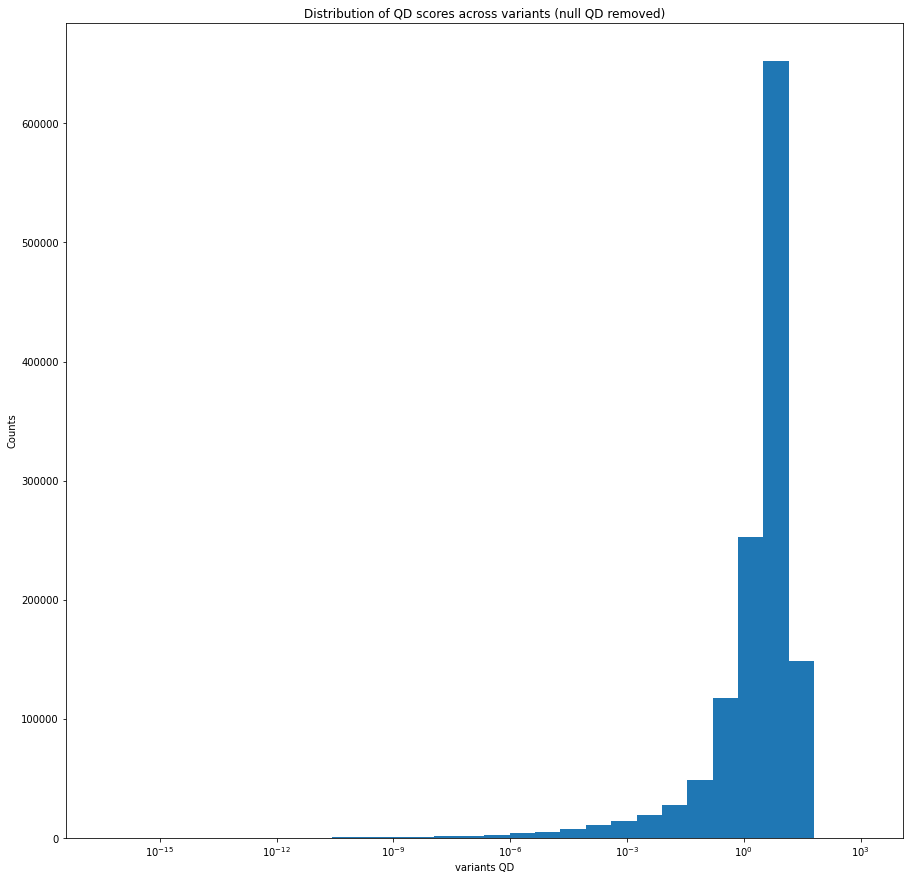

67732 ( 4.9 % ) variants with a QD of 0


In [19]:
plot_loghist(QD[QD > 0],
             xlab = "variants QD", 
             ylab = "Counts", 
             title = "Distribution of QD scores across variants (null QD removed)")
nb_null = np.sum(QD == 0)
perc_null = 100 * nb_null / len(QD)
print(nb_null, "(", round(perc_null, 1), "% ) variants with a QD of 0")